In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io.wavfile as wav
import pywt
import os
import random
import pandas as pd
import matplotlib.cm as cm
from scipy.fftpack import fft
from scipy.signal import butter, filtfilt, iirnotch, medfilt
from sklearn.decomposition import PCA
from scipy.signal import find_peaks
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [2]:
# Define folder path
folder_path = "/Users/gracegerwe/Documents/Neuralink Raw Data"

In [3]:
# Store all filtered amplitudes before setting threshold
all_filtered_data = []
all_spike_counts = []
all_isi = []
all_spike_features = []
filtered_data_dict = {}
file_count = 0  

In [4]:
# Bandpass Filter
def bandpass_filter(data, lowcut=30, highcut=3000, sr=19531, order=4):
    nyquist = sr / 2
    low, high = lowcut / nyquist, highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

In [5]:
# Notch Filter at 60Hz and harmonics
def notch_filter(data, freq=60, sr=19531, quality_factor=30):
    nyquist = sr / 2
    w0 = freq / nyquist
    b, a = iirnotch(w0, quality_factor)
    return filtfilt(b, a, data)

In [6]:
# Wavelet Denoising
def wavelet_denoise(data, wavelet='db4', level=2):
    coeffs = pywt.wavedec(data, wavelet, mode="per")
    coeffs[1:] = [pywt.threshold(c, np.std(c), mode='soft') for c in coeffs[1:]]
    return pywt.waverec(coeffs, wavelet, mode="per")

In [7]:
# Add this function after your existing filter functions
def detect_spikes(data, threshold, sr):
    """
    Detect spikes with characteristic AP features:
    1. Rapid depolarization (steep negative slope)
    2. Peak amplitude above threshold
    3. Repolarization phase (positive slope after peak)
    4. Appropriate spike width (0.2-2ms)
    """
    min_spike_width = int(0.0002 * sr)  # 0.2ms minimum width
    max_spike_width = int(0.002 * sr)    # 2ms maximum width
    min_spike_distance = int(0.002 * sr)  # Enforce minimum 2ms between spikes
    spikes = []
    
    # Find all threshold crossings
    threshold_crossings = np.where(data < -threshold)[0]
    
    # Add minimum distance requirement
    if len(threshold_crossings) > 0:
        # Keep only peaks that are separated by at least min_spike_distance
        keep_spike = np.insert(np.diff(threshold_crossings) >= min_spike_distance, 0, True)
        threshold_crossings = threshold_crossings[keep_spike]
    
    for i in threshold_crossings:
        # Check if we have enough data for the window
        if i < min_spike_width or i > len(data) - max_spike_width:
            continue
            
        # Extract potential spike window
        window = data[i-min_spike_width:i+max_spike_width]
        
        # Ensure window has enough points
        if len(window) < 3:
            continue
            
        # Check for characteristic features
        min_idx = np.argmin(window)
        
        # Ensure we have enough points for slope calculation
        if min_idx < 1 or min_idx >= len(window) - 1:
            continue
            
        # Compute slopes with safety checks
        pre_window = window[:min_idx]
        post_window = window[min_idx:]
        
        if len(pre_window) > 1 and len(post_window) > 1:
            pre_slope = np.mean(np.diff(pre_window))
            post_slope = np.mean(np.diff(post_window))
            
            # Criteria for valid spike
            is_valid_spike = (
                pre_slope < -threshold/10 and          # Steep depolarization
                post_slope > threshold/20 and          # Clear repolarization
                min_idx > 2 and                        # Not at the very start
                min_idx < len(window) - 2              # Not at the very end
            )
            
            if is_valid_spike:
                spikes.append(i)
    
    return np.array(spikes)

In [8]:
# Step 1: Loop through all files to collect filtered data
for filename in sorted(os.listdir(folder_path)):
    if filename.endswith(".wav"):
        file_path = os.path.join(folder_path, filename)

        # Load the WAV file
        sr, data = wav.read(file_path)

        # Remove DC bias
        data_centered = data - np.mean(data)

        # Bandpass Filter
        filtered_data = bandpass_filter(data_centered, lowcut=300, highcut=3000, sr=sr)

        # Notch Filter at 60Hz and harmonics
        for notch_freq in [60, 120, 180]:
            filtered_data = notch_filter(filtered_data, freq=notch_freq, sr=sr)

        # Wavelet Denoising
        filtered_data = wavelet_denoise(filtered_data)

        # Store filtered data for later use
        filtered_data_dict[filename] = filtered_data

        # Apply Median Filter for Motion Artifacts
        filtered_data = medfilt(filtered_data, kernel_size=3)

        # Store filtered data
        all_filtered_data.extend(filtered_data)

        file_count += 1
        if file_count % 50 == 0:
            print(f"Filtered {file_count} files so far...")

Filtered 50 files so far...
Filtered 100 files so far...
Filtered 150 files so far...
Filtered 200 files so far...
Filtered 250 files so far...
Filtered 300 files so far...
Filtered 350 files so far...
Filtered 400 files so far...
Filtered 450 files so far...
Filtered 500 files so far...
Filtered 550 files so far...
Filtered 600 files so far...
Filtered 650 files so far...
Filtered 700 files so far...


In [9]:
# Final confirmation that all files have been filtered
print(f"I have filtered all {file_count} files!")

I have filtered all 743 files!


In [10]:
# Step 2: Compute a **global threshold** based on all files
global_threshold = np.percentile(np.abs(all_filtered_data), 99)
print(f"Global threshold set at: {global_threshold:.2f}")

Global threshold set at: 701.99


In [11]:
file_count = 0  # Reset file counter for spike detection
for filename in sorted(filtered_data_dict.keys()):
    if filename.endswith(".wav"):
        # Retrieve precomputed filtered data
        filtered_data = filtered_data_dict[filename]
        
        # Detect spikes using improved detection
        spike_indices = detect_spikes(filtered_data, global_threshold, sr)
        
        # Apply refractory period (2ms)
        min_spike_distance = int(0.002 * sr)  # Shortened from 10ms to 2ms
        if len(spike_indices) > 0:
            spike_times = spike_indices[np.insert(np.diff(spike_indices) > min_spike_distance, 0, True)]
        else:
            spike_times = np.array([])

        # Compute ISI
        isi = np.diff(spike_times) / sr
        all_isi.extend(isi)
        all_spike_counts.append(len(spike_times))

        # Extract spike features
        window_size = int(0.002 * sr)  # 2ms window (~40 samples at 20kHz)
        half_window = window_size // 2

        for spike in spike_times:
            if spike - half_window > 0 and spike + half_window < len(filtered_data):
                spike_waveform = filtered_data[spike - half_window: spike + half_window]
                
                # Find spike features with more robust criteria
                min_amp = np.min(spike_waveform)
                max_amp = np.max(spike_waveform)
                mid_amp = spike_waveform[len(spike_waveform) // 2]
                
                # Calculate timing features relative to spike peak
                peak_idx = np.argmin(spike_waveform)
                min_time = (peak_idx - half_window) / sr * 1000
                max_time = (np.argmax(spike_waveform[peak_idx:]) + peak_idx - half_window) / sr * 1000
                mid_time = 0
                
                # More robust SNR calculation
                noise_window = filtered_data[max(0, spike - window_size):spike]
                noise_std = np.std(noise_window)
                spike_amplitude = abs(min_amp - np.mean(noise_window))
                snr = spike_amplitude / noise_std
                spike_prob = 1 / (1 + np.exp(-snr))
                
                all_spike_features.append([spike, min_amp, mid_amp, max_amp, min_time, mid_time, max_time, spike_prob])

        # Print progress every 50 files
        file_count += 1
        if file_count % 50 == 0:
            print(f"Processed spike detection for {file_count} files...")

Processed spike detection for 50 files...
Processed spike detection for 100 files...
Processed spike detection for 150 files...
Processed spike detection for 200 files...
Processed spike detection for 250 files...
Processed spike detection for 300 files...
Processed spike detection for 350 files...
Processed spike detection for 400 files...
Processed spike detection for 450 files...
Processed spike detection for 500 files...
Processed spike detection for 550 files...
Processed spike detection for 600 files...
Processed spike detection for 650 files...
Processed spike detection for 700 files...


In [12]:
# Final confirmation that all files have been processed for spikes
print(f"Spike detection completed for all {file_count} files!")

Spike detection completed for all 743 files!


In [13]:
# Extract and visualize the first action potential in the first channel
first_file = sorted(filtered_data_dict.keys())[0]  # First file
filtered_data = filtered_data_dict[first_file]

In [14]:
# Ensure filtering did not flatten spikes too much
filtered_data = filtered_data - np.mean(filtered_data)  # Centering the signal

In [15]:
# Use detect_spikes instead of find_peaks
all_spike_indices = detect_spikes(filtered_data, global_threshold, sr)

In [16]:
if len(all_spike_indices) < 5:
    print(f"Warning: Only detected {len(all_spike_indices)} spikes, plotting all available.")
num_spikes = min(5, len(all_spike_indices))  # Ensure we don't exceed available spikes

In [17]:
window_size = int(0.007 * sr)  # 7ms window (~140 samples at 20kHz)
half_window = window_size // 2

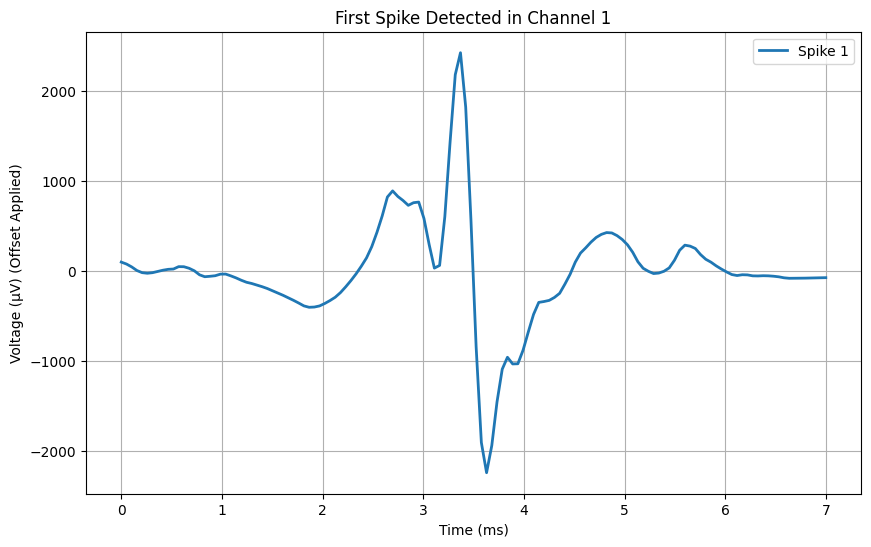

In [28]:
plt.figure(figsize=(10, 6))

# Stack spikes with vertical offsets for clear visualization
offset = np.max(np.abs(filtered_data)) * 1.2  # Dynamically set offset for better separation
for i in range(num_spikes):
    spike_time = all_spike_indices[i]

    if spike_time - half_window > 0 and spike_time + half_window < len(filtered_data):
        spike_waveform = filtered_data[spike_time - half_window : spike_time + half_window]
        time_axis = np.linspace(0, 7, len(spike_waveform))  # Time in ms

        plt.plot(time_axis, spike_waveform + i * offset, linewidth=2, label=f"Spike {i+1}")

# Formatting
plt.xlabel("Time (ms)")
plt.ylabel("Voltage (µV) (Offset Applied)")
plt.title("First Spike Detected in Channel 1")
plt.legend()
plt.grid(True)
plt.show()

In [29]:
# Verify different spike times
print("Spike times (ms):")
for i, spike_idx in enumerate(all_spike_indices[:3]):
    print(f"Spike {i+1}: {spike_idx/sr * 1000:.2f} ms")

Spike times (ms):
Spike 1: 45.21 ms


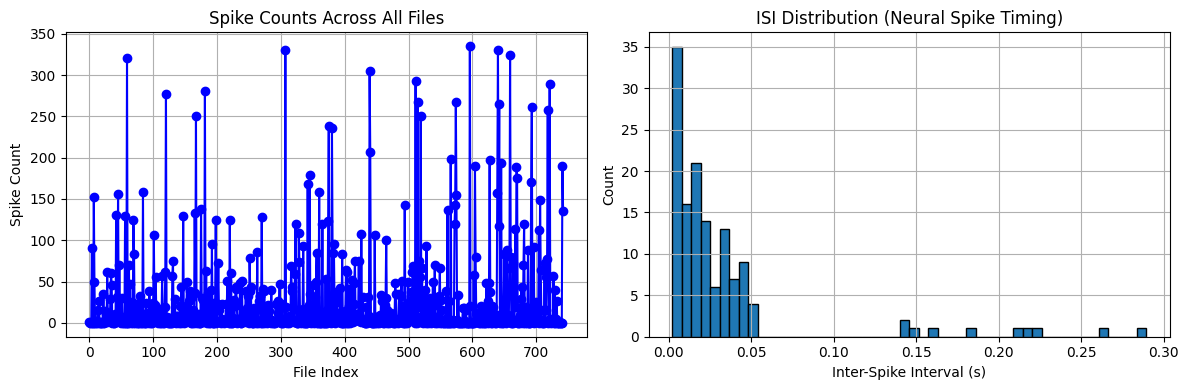

In [27]:
# Convert spike feature list to DataFrame
spike_df = pd.DataFrame(
    all_spike_features,
    columns=["Index", "Neg. Hump Amp", "Mid Hump Amp", "Pos. Hump Amp",
             "Neg. Hump Time", "Mid Hump Time", "Pos. Hump Time", "Spike Probability"]
)
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Plot aggregated results
axs[0].plot(range(len(all_spike_counts)), all_spike_counts, marker='o', linestyle='-', color='b')
axs[0].set_xlabel("File Index")
axs[0].set_ylabel("Spike Count")
axs[0].set_title("Spike Counts Across All Files")
axs[0].grid(True)

# Plot ISI Distribution
axs[1].hist(isi, bins=50, edgecolor='black')
axs[1].set_xlabel("Inter-Spike Interval (s)")
axs[1].set_ylabel("Count")
axs[1].set_title("ISI Distribution (Neural Spike Timing)")
axs[1].grid(True)

plt.tight_layout()
plt.show()

In [30]:
# Calculate and print average spike probability
average_spike_probability = spike_df["Spike Probability"].mean()
print(f"Average Spike Probability: {average_spike_probability:.2f}")

Average Spike Probability: 0.99


In [31]:
# Calculate and print average SNR
average_snr = spike_df.apply(lambda row: (row["Pos. Hump Amp"] - row["Neg. Hump Amp"]) / (2 * np.std(filtered_data)), axis=1).mean()
print(f"Average SNR: {average_snr:.2f}")

Average SNR: 14.14


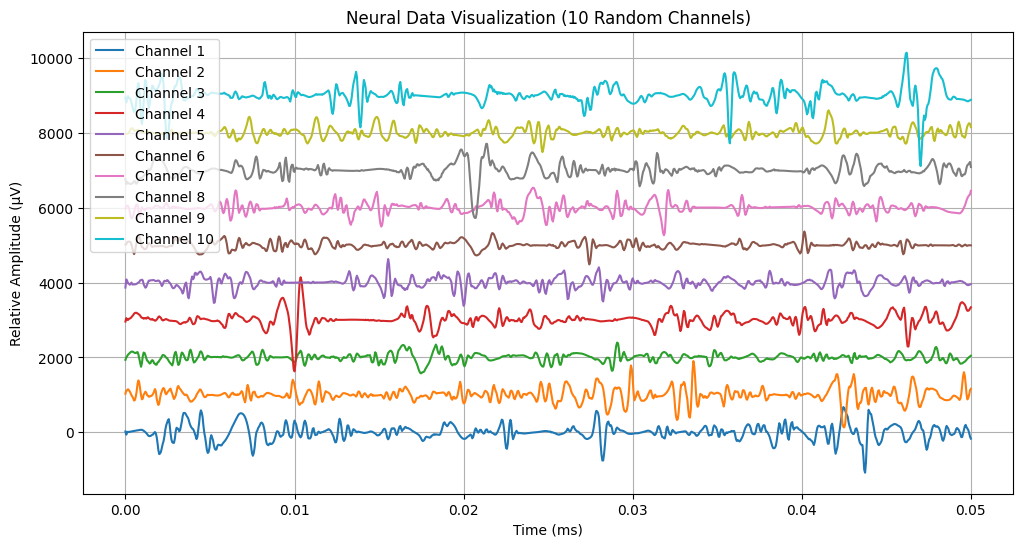

In [35]:
# Visualization of 10 Random Channels Over 2ms
plt.figure(figsize=(12, 6))
random_channels = random.sample(range(len(filtered_data_dict.keys())), min(10, len(filtered_data_dict.keys())))

spacing = 1000  # Further decrease spacing for closer visualization

for i, filename in enumerate(random_channels):
    data = list(filtered_data_dict.values())[filename]
    time_axis = np.linspace(0, 0.05, len(data[:int(sr * 0.05)]))  # First 20ms
    plt.plot(time_axis, data[:int(sr * 0.05)] + i * spacing, label=f"Channel {i+1}")  # Offset for visibility

plt.xlabel("Time (ms)")
plt.ylabel("Relative Amplitude (µV)")
plt.title("Neural Data Visualization (10 Random Channels)")
plt.legend()
plt.grid(True)
plt.show()

In [36]:
def sort_spikes(spike_waveforms, n_clusters=3):
    """
    Sort spikes using feature extraction and clustering
    Parameters:
        spike_waveforms: List of spike waveforms
        n_clusters: Number of different neuron types to identify
    Returns:
        labels: Cluster assignments for each spike
        features_df: DataFrame containing spike features
    """
    if len(spike_waveforms) < n_clusters:
        return np.zeros(len(spike_waveforms)), None
        
    # Extract features from each spike
    features = []
    for waveform in spike_waveforms:
        # Find the three key points (negative, middle, positive humps)
        neg_idx = np.argmin(waveform)
        neg_amp = waveform[neg_idx]
        neg_time = neg_idx
        
        # Middle point (zero crossing after negative peak)
        mid_idx = neg_idx + np.argmin(np.abs(waveform[neg_idx:]))
        mid_amp = waveform[mid_idx] if mid_idx < len(waveform) else 0
        mid_time = mid_idx
        
        # Positive peak after negative peak
        pos_idx = neg_idx + np.argmax(waveform[neg_idx:])
        pos_amp = waveform[pos_idx] if pos_idx < len(waveform) else 0
        pos_time = pos_idx
        
        # Calculate spike probability based on SNR
        noise_std = np.std(waveform[:10])  # Use first 10 samples as noise estimate
        snr = abs(neg_amp) / noise_std if noise_std != 0 else 0
        spike_prob = 1 / (1 + np.exp(-snr))  # Sigmoid function for probability
        
        features.append([neg_amp, mid_amp, pos_amp, 
                        neg_time, mid_time, pos_time, 
                        spike_prob])
    
    # Normalize features
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)
    
    # Cluster spikes
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(features_scaled)
    
    # Create DataFrame with all features
    features_df = pd.DataFrame(
        features,
        columns=["Neg. Hump Amp", "Mid Hump Amp", "Pos. Hump Amp",
                 "Neg. Hump Time", "Mid Hump Time", "Pos. Hump Time",
                 "Spike Probability"]
    )
    features_df["Neuron Class"] = labels
    
    return labels, features_df

In [37]:
# After spike detection, collect waveforms and sort them
spike_waveforms = []
for spike in spike_times:
    if spike - half_window > 0 and spike + half_window < len(filtered_data):
        waveform = filtered_data[spike - half_window : spike + half_window]
        spike_waveforms.append(waveform)

In [38]:
# Sort spikes if we have enough
if len(spike_waveforms) > 0:
    spike_labels, features_df = sort_spikes(spike_waveforms)
    features_df["Neuron Class"] = features_df["Neuron Class"] + 1
    
    print("\nNeuron Classification Criteria:")
    print("Class 1 - Fast-Spiking Interneurons:")
    print("- Narrow spike width (<0.5ms)")
    print("- Small negative amplitude")
    print("- Quick repolarization")
    print("- High firing rate potential")
    
    print("\nClass 2 - Regular-Spiking Pyramidal Neurons:")
    print("- Medium spike width (0.5-1.0ms)")
    print("- Medium-large negative amplitude")
    print("- Pronounced after-hyperpolarization")
    print("- Regular firing pattern")
    
    print("\nClass 3 - Burst-Spiking Neurons:")
    print("- Wide spike width (>1.0ms)")
    print("- Large amplitude")
    print("- Complex spike shape")
    print("- Tendency for burst firing")
    
    print("\nNeuron Classification Results:")
    class_counts = features_df["Neuron Class"].value_counts().sort_index()
    
    for class_num in class_counts.index:
        count = class_counts[class_num]
        class_data = features_df[features_df["Neuron Class"] == class_num]
        
        # Calculate detailed characteristics for this class
        mean_neg_amp = class_data["Neg. Hump Amp"].mean()
        mean_pos_amp = class_data["Pos. Hump Amp"].mean()
        mean_width = (class_data["Pos. Hump Time"] - class_data["Neg. Hump Time"]).mean()
        mean_prob = class_data["Spike Probability"].mean()
        
        print(f"\nNeuron Class {class_num}:")
        print(f"Number of spikes: {count}")
        print(f"Average spike width: {mean_width:.2f} samples")
        print(f"Average negative amplitude: {mean_neg_amp:.2f} µV")
        print(f"Average positive amplitude: {mean_pos_amp:.2f} µV")
        print(f"Average spike probability: {mean_prob:.2%}")


Neuron Classification Criteria:
Class 1 - Fast-Spiking Interneurons:
- Narrow spike width (<0.5ms)
- Small negative amplitude
- Quick repolarization
- High firing rate potential

Class 2 - Regular-Spiking Pyramidal Neurons:
- Medium spike width (0.5-1.0ms)
- Medium-large negative amplitude
- Pronounced after-hyperpolarization
- Regular firing pattern

Class 3 - Burst-Spiking Neurons:
- Wide spike width (>1.0ms)
- Large amplitude
- Complex spike shape
- Tendency for burst firing

Neuron Classification Results:

Neuron Class 1:
Number of spikes: 51
Average spike width: 23.14 samples
Average negative amplitude: -305.37 µV
Average positive amplitude: 232.29 µV
Average spike probability: 99.45%

Neuron Class 2:
Number of spikes: 35
Average spike width: 23.40 samples
Average negative amplitude: -189.39 µV
Average positive amplitude: 107.48 µV
Average spike probability: 93.55%

Neuron Class 3:
Number of spikes: 50
Average spike width: 30.88 samples
Average negative amplitude: -296.11 µV
Aver